In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

from pathlib import Path
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from pathlib import Path
from pymatgen.core import Structure, Composition, Element

# user-friendly print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# see https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
import torch
torch.set_float32_matmul_precision('high')

### Load data

In [2]:
qc_ac_te_mp_dataset = pd.read_pickle('../data/raw/qc_ac_te_mp_rebuild_T=290K_20250202.pd.xz')

qc_ac_te_mp_dataset.head(3)
qc_ac_te_mp_dataset.shape

,formula,hypermaterial_type,temperature,composition,elements,Thermal conductivity,Seebeck coefficient,Carrier concentration,Electrical conductivity,Thermopower,...,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume,Magnetic susceptibility,Hall coefficient,Electronic contribution,Electronic thermal conductivity
id,,,,,,,,,,,,,,,,,,,,,
starry_0,(ErAs)0.003InGaAs,others,290,"(Er, As, In, Ga)","(Er, As, In, Ga)",3.2670491071158483,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,Al61.5Cu26.5Fe12,IQC,290,"(Al, Cu, Fe)","(Al, Cu, Fe)",1.4258964578008275,-1.1863527516689362e-05,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,Bi2Te2.4Se0.6,others,290,"(Bi, Te, Se)","(Bi, Te, Se)",NaN,NaN,-5.436073908332581e+24,1063.8779641515926,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(41017, 26)

All properties

In [3]:
starry_props = [
    "Thermal conductivity",
    "Carrier concentration",
    "Electrical conductivity",
    "Thermopower",
    "Electrical resistivity",
    "Power factor",
    "Seebeck coefficient",
    "Lattice thermal conductivity",
    "ZT",
    "Hall mobility",
    "Electronic contribution",  # Nan after QuantileTransformer
    "Electronic thermal conductivity",
]

ac_qc_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Magnetic susceptibility",
    # "Specific heat capacity",
    "Hall coefficient",
    "ZT",
    "Power factor",
]

mp_props = [
    "Band gap",
    "Density",
    "Efermi",
    "Final energy per atom",
    "Formation energy per atom",
    "Total magnetization",
    "Volume",  
]

ac_qc_starry_shared_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Power factor",
    "ZT",
]

ac_qc_starry_props = [
    "Seebeck coefficient",
    "Thermal conductivity",
    "Electrical resistivity",
    "Magnetic susceptibility",
    # "Specific heat capacity",
    "Hall coefficient",
    "ZT",
    "Power factor",
    "Carrier concentration",
    "Electrical conductivity",
    "Thermopower",
    "Lattice thermal conductivity",
    "Hall mobility",
    "Electronic contribution",
    "Electronic thermal conductivity",
]

all_props = ac_qc_starry_props + mp_props

qc_ac_te_mp_props = qc_ac_te_mp_dataset[all_props]

Calculate descriptors

In [4]:
from xenonpy.descriptor import Compositions
from sklearn.preprocessing import MinMaxScaler, StandardScaler

featurizers = ['WeightedAverage', 'WeightedVariance', 'MaxPooling', 'MinPooling']
comp_calc = Compositions(featurizers=featurizers, n_jobs=20)  # use specific featurizers

In [5]:
all_comp_desc = comp_calc.fit_transform(qc_ac_te_mp_dataset).dropna()
qc_ac_te_mp_props = qc_ac_te_mp_props.loc[all_comp_desc.index]

all_comp_desc.shape
all_comp_desc.head(3)

(40975, 232)

,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
id,,,,,,,,,,,,,,,,,,,,,
starry_0,37.692282,148.686294,236.696274,13.537758,86.556599,1968.408516,61.147068,454.500998,127.719228,129.027944,...,2.0,4.0,0.168,15.00,185.0,188.0,236.0,339.1,1215.0,4.31
qa_1,18.800000,136.985000,231.610000,8.883500,40.134736,2800.460000,104.240000,455.520000,126.435000,121.090000,...,1.0,3.0,0.385,80.00,184.0,225.0,223.0,291.2,3570.0,6.20
starry_2,62.240000,161.600000,243.040000,20.340000,154.316680,1474.412000,44.596000,459.240000,139.840000,139.600000,...,2.0,4.0,0.124,0.52,190.0,182.0,229.0,420.5,1790.0,3.77


Data transform to get normalized data

In [6]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal').set_output(transform="pandas")

qc_ac_te_mp_props = qt.fit_transform(qc_ac_te_mp_props)

joblib.dump(qt, '../data/qc_ac_te_mp_quantile_transformer.pkl.z', protocol=5)
qc_ac_te_mp_props.shape
qc_ac_te_mp_props.head(3)
qc_ac_te_mp_props.isna().all(axis=0)

['../data/qc_ac_te_mp_quantile_transformer.pkl.z']

(40975, 21)

,Seebeck coefficient,Thermal conductivity,Electrical resistivity,Magnetic susceptibility,Hall coefficient,ZT,Power factor,Carrier concentration,Electrical conductivity,Thermopower,...,Hall mobility,Electronic contribution,Electronic thermal conductivity,Band gap,Density,Efermi,Final energy per atom,Formation energy per atom,Total magnetization,Volume
id,,,,,,,,,,,,,,,,,,,,,
starry_0,NaN,-0.042294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
qa_1,-0.387932,-0.887815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
starry_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5.199338,-1.15607,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Seebeck coefficient                False
Thermal conductivity               False
Electrical resistivity             False
Magnetic susceptibility            False
Hall coefficient                   False
ZT                                 False
Power factor                       False
Carrier concentration              False
Electrical conductivity            False
Thermopower                        False
Lattice thermal conductivity       False
Hall mobility                      False
Electronic contribution            False
Electronic thermal conductivity    False
Band gap                           False
Density                            False
Efermi                             False
Final energy per atom              False
Formation energy per atom          False
Total magnetization                False
Volume                             False
dtype: bool

----

## NN model

In [7]:
used_props = qc_ac_te_mp_props[all_props].dropna(how='all')
used_desc = all_comp_desc.loc[used_props.index]

In [8]:
from foundation_model.configs.model_config import ExperimentConfig, ModelConfig
from foundation_model.data.datamodule import CompoundDataModule
from foundation_model.data.preprocessor import AttributePreprocessor
from foundation_model.data.splitter import MultiTaskSplitter
from foundation_model.models.multi_task import MultiTaskAttributePredictor
from foundation_model.utils.training import training

In [9]:
# Prepare datasets
property_fractions = {
    'Seebeck coefficient': 1.,
    'Thermal conductivity': 0.1,
    'Electrical resistivity': 0.1,
    'Magnetic susceptibility': 1.,
    # 'Specific heat capacity': 1.,
    'Electrical conductivity': 1.,
    'ZT': 1.,
    'Hall coefficient': 1.,
    'Power factor': 1.,
    'Carrier concentration': 1.,
    'Thermopower': 1.,
    'Lattice thermal conductivity': 1.,
    'Hall mobility': 1.,
    'Electronic contribution': 1.,
    'Electronic thermal conductivity': 1.,
    'Band gap': .1,
    'Density': .1,
    'Efermi': .1,
    'Final energy per atom': .1,
    'Formation energy per atom': .1,
    'Total magnetization': .1,
    'Volume': .1
}

In [10]:
preprocessor = AttributePreprocessor(attribute_rates=property_fractions)
processed_attrs = preprocessor.process(used_props)

In [11]:
splitter = MultiTaskSplitter(
    train_ratio=0.8, val_ratio=0.2, test_ratio=0.0, random_state=42
)

In [12]:
train_idx, val_idx, _ = splitter.split(processed_attrs)

In [13]:
datamodule = CompoundDataModule(
    descriptor=used_desc,
    attributes=processed_attrs,
    train_idx=train_idx,
    val_idx=val_idx,
    batch_size=128,
    num_workers=0,
)

In [14]:
# Initialize model
shared_block_dims = [used_desc.shape[1], 128, 64]
task_block_dims = [64, 32, 16, 1]
model = MultiTaskAttributePredictor(
    shared_block_dims=shared_block_dims,
    task_block_dims=task_block_dims,
    n_tasks=len(processed_attrs.columns),
    norm_shared=True,
    norm_tasks=True,
    residual_shared=True,
    residual_tasks=True,
    shared_block_lr=0.001,
    task_block_lr=0.01
)
# model
# model = torch.compile(model)

In [19]:
ckpt_path = Path('../results/20250206_1_logs/common_logs/mp_1.0-shared_lr=0.001_task_lr=0.01/version_0/checkpoints/last.ckpt')
model = MultiTaskAttributePredictor.load_from_checkpoint(ckpt_path, map_location='cpu')


In [24]:
import lightning as L
trainer = L.Trainer()

datamodule.setup()
predictions = trainer.predict(model, dataloaders=datamodule.val_dataloader())

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/.miniforge3/envs/xepy311/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [25]:
all_preds = []
all_targets = []
all_masks = []

for part in predictions:
    preds, targets, masks, _ = part.values()
    all_preds.append(preds)
    all_targets.append(targets)
    all_masks.append(masks)

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
all_masks = np.concatenate(all_masks)

In [28]:
from foundation_model.utils.plotting import plot_scatter_comparison, plot_predictions

def plot_predictions(
    all_preds: np.ndarray,
    all_targets: np.ndarray,
    all_masks: np.ndarray,
    attributes: list[str],
    *,
    savefig: Optional[str] = None,
    suffix: Optional[str] = None,
    no_show: bool = False,
    return_stat: bool = False,
) -> Optional[Dict]:
    """
    Generate scatter plots comparing predicted and target values for multiple attributes.

    Parameters
    ----------
    all_preds : np.ndarray
        Array containing prediction values
    all_targets : np.ndarray
        Array containing target values
    all_masks : np.ndarray
        Array containing mask indicators (1 for valid entries)
    attributes : list[str]
        List of attribute names
    savefig : str, optional
        Directory path to save plots
    suffix : str, optional
        String suffix for save directory
    no_show : bool, optional
        Whether to clear figures after creation
    return_stat : bool, optional
        Whether to return statistics dictionary

    Returns
    -------
    Optional[Dict]
        Dictionary containing statistics for each attribute if return_stat is True
    """
    all_stats = []
    for m in range(len(attributes)):
        mask_m = all_masks[:, m] == 1
        preds_m = all_preds[mask_m, m]
        targets_m = all_targets[mask_m, m]

        try:
            # Create scatter plot
            fig, _, stat = plot_scatter_comparison(
                targets_m, preds_m, title=attributes[m], return_stat=True
            )
        except ValueError:
            continue

        # Save figure if path provided
        if savefig and isinstance(savefig, str):
            from pathlib import Path

            savefig_ = f"{savefig}/{suffix if suffix else ''}"
            _ = Path(savefig_).mkdir(parents=True, exist_ok=True)
            fig.savefig(f"{savefig_}/{attributes[m]}.png", bbox_inches="tight")

        stat["attribute"] = attributes[m]
        all_stats.append(stat)

        if no_show:
            plt.cla()
            plt.clf()
            plt.close()

    if return_stat:
        import pandas as pd

        return pd.DataFrame(all_stats)
    return None


NameError: name 'Optional' is not defined

In [26]:
from foundation_model.utils.plotting import plot_predictions

ValueError: Cannot calculate a linear regression if all x values are identical

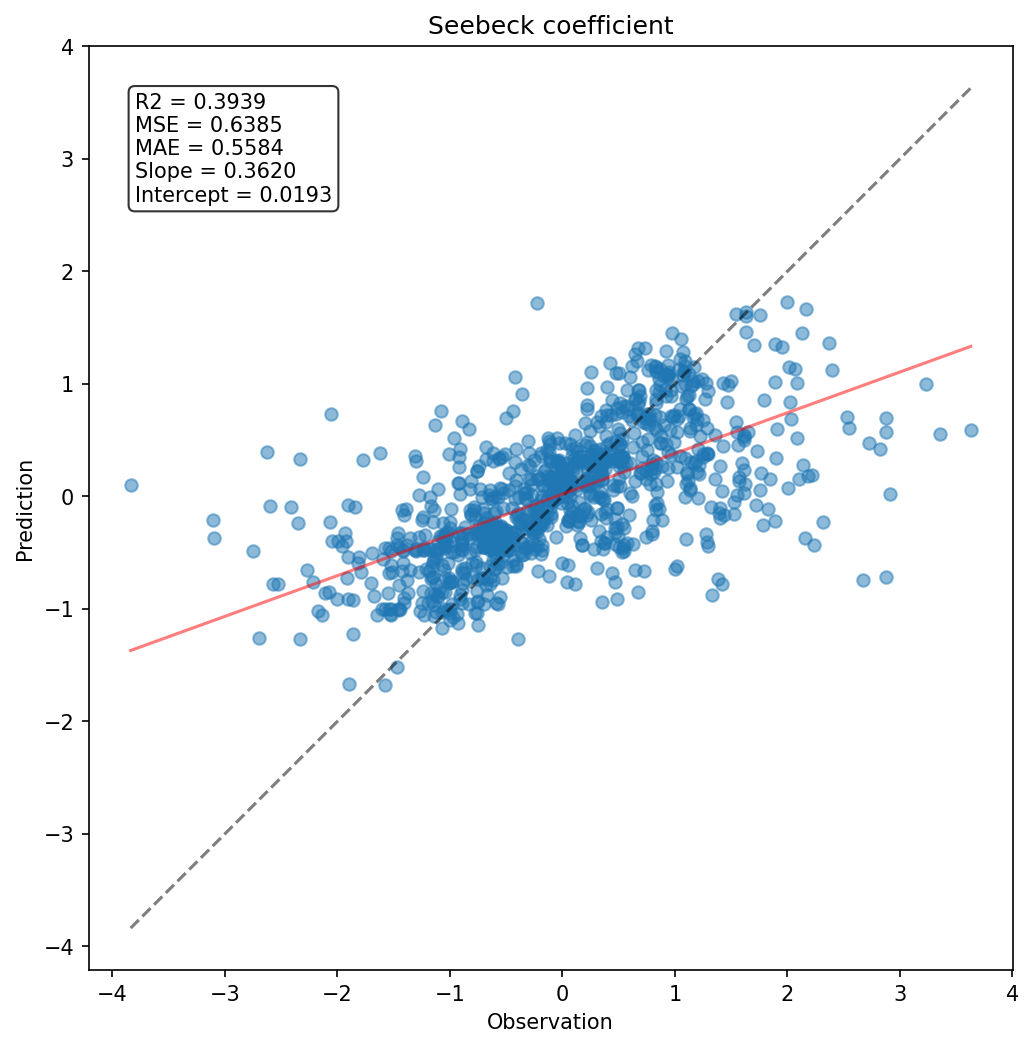

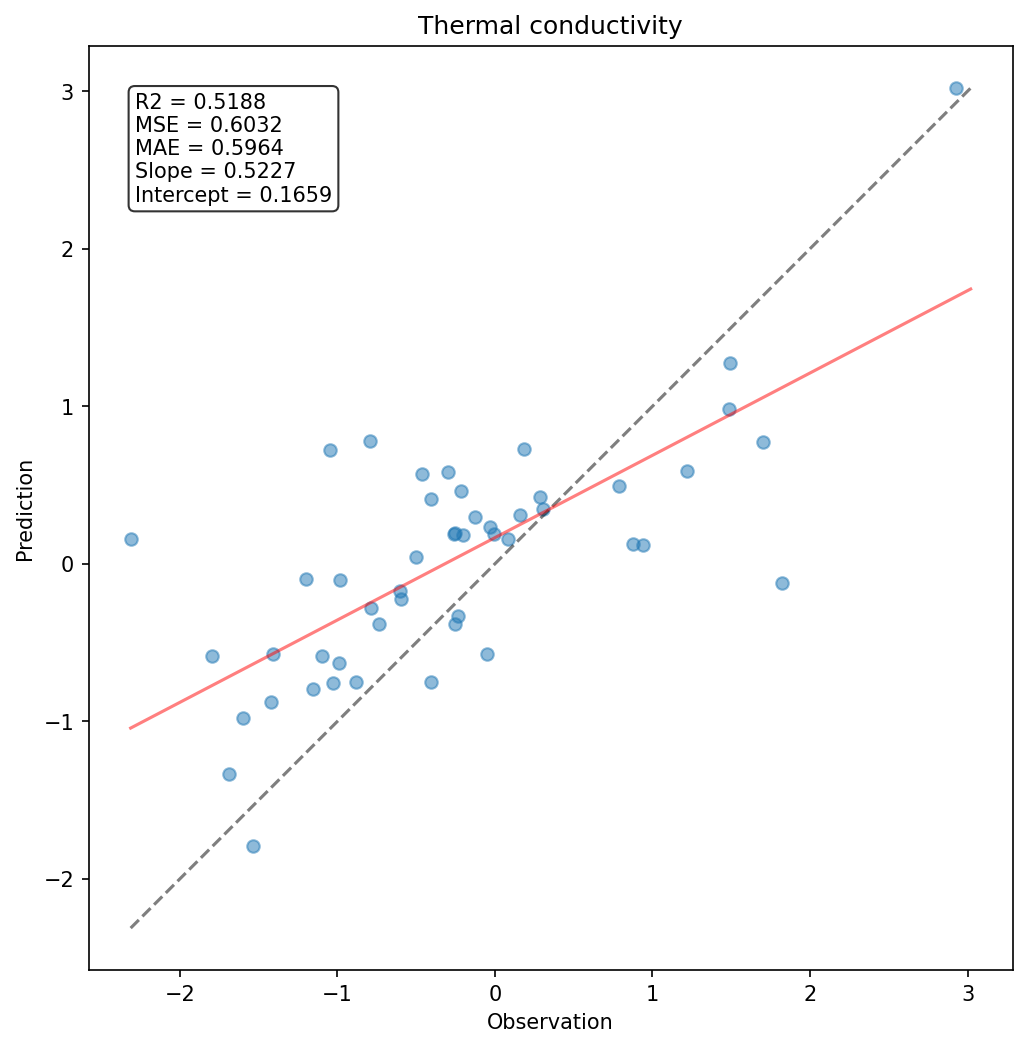

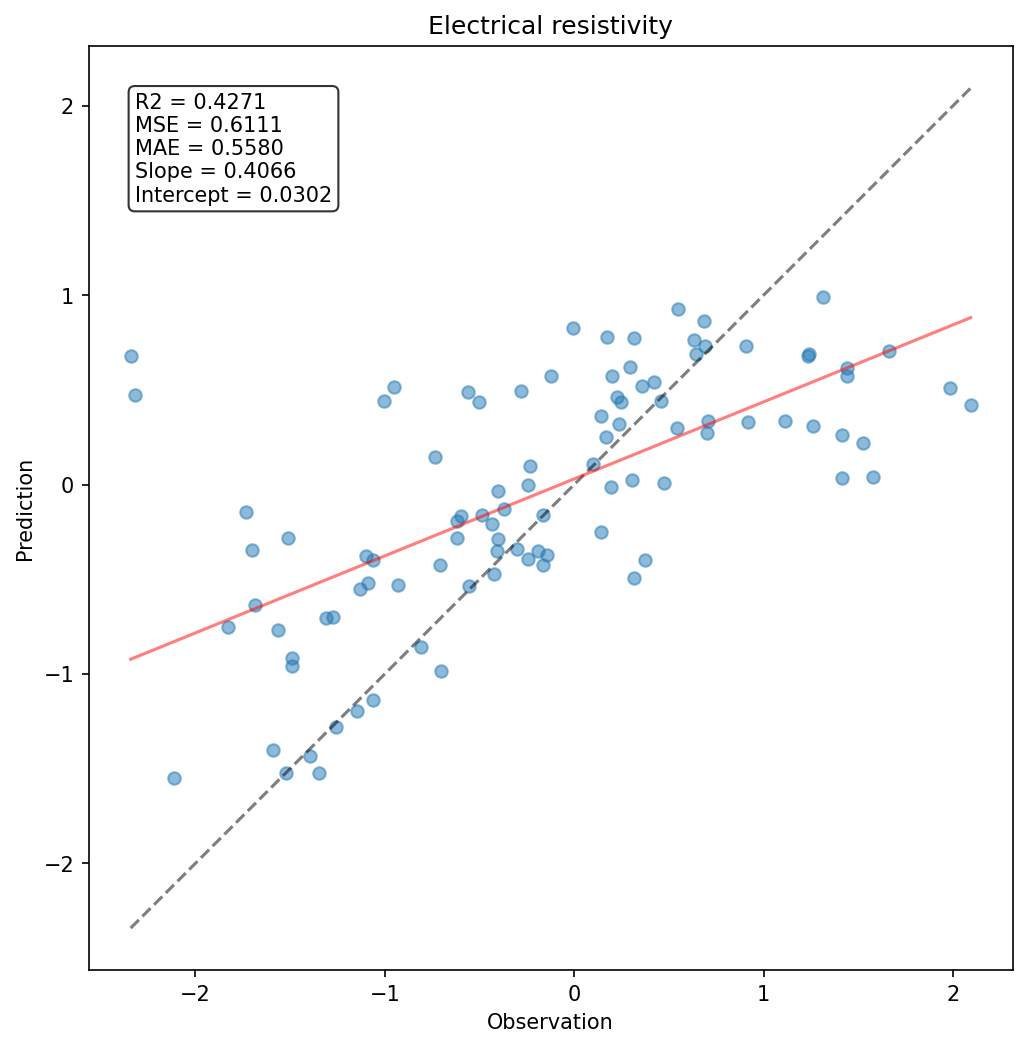

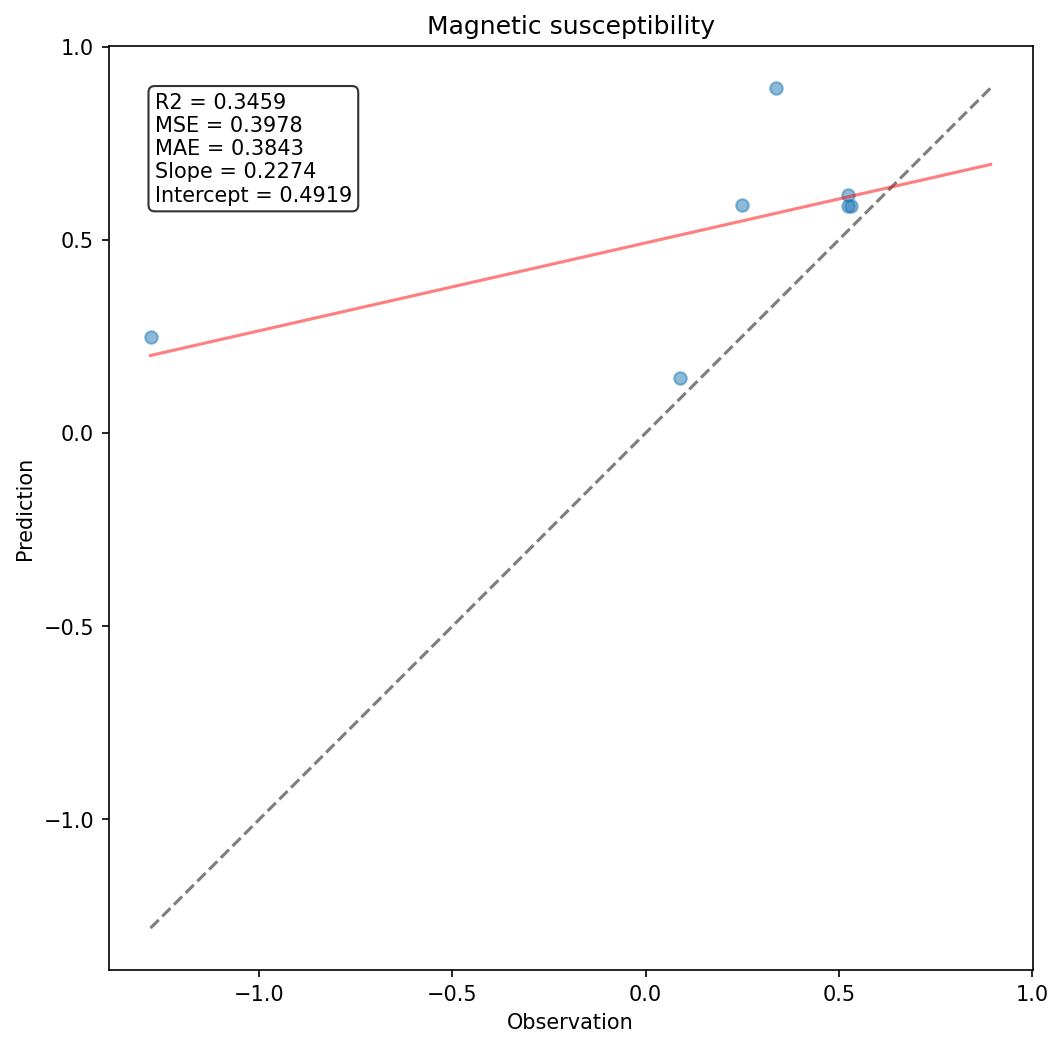

In [27]:
attributes = processed_attrs.columns
plot_predictions(all_preds, all_targets, all_masks, attributes=attributes, savefig='images/multi_tasks/', suffix='all_qc_ac_te_data', return_stat=True)

---------

In [ ]:
%run multi_task.py
%run plot_utils.py

In [22]:
from typing import Optional, Dict, List, Tuple
import torch
import pandas as pd
from pathlib import Path
# from multi_task import scaling_laws_test, CompoundDataset

def test_all_properties(
    descriptor_df: pd.DataFrame,
    property_df: pd.DataFrame,
    device: str = 'cuda'
) -> Dict[str, Dict[str, Tuple[List[float], List[float], List[float]]]]:
    """
    Test scaling laws for all properties in both vary_target and vary_others modes.
    
    Args:
        descriptor_df: DataFrame containing input features
        property_df: DataFrame containing property values
        device: Device to run the model on ('cpu' or 'cuda')
    
    Returns:
        Dict with structure:
        {
            property_name: {
                'vary_target': (test_losses, test_losses_std, fractions),
                'vary_others': (test_losses, test_losses_std, fractions)
            }
        }
        where:
        - test_losses: List of mean test losses for each fraction
        - test_losses_std: List of standard deviations of test losses
        - fractions: List of data fractions used
    """
    results: Dict[str, Dict[str, Tuple[List[float], List[float], List[float]]]] = {}
    
    # Create results directory
    results_dir = Path('images/multi_tasks/scaling_laws')
    results_dir.mkdir(parents=True, exist_ok=True)
    
    # Test each property
    for property_name in CompoundDataset.ATTRIBUTES:
        if property_name != 'seebeck_coefficient':
            continue
        results[property_name] = {}
        print(f"\n{'='*80}")
        print(f"Testing scaling laws for {property_name}")
        print(f"{'='*80}")
        
        # Test vary_target mode
        print(f"\nMode: vary_target (varying {property_name} data while fixing others)")
        results[property_name]['vary_target'] = scaling_laws_test(
            descriptor=descriptor_df,
            property_data=property_df,
            target_property=property_name,
            mode='vary_target',
            device=device
        )
        
        # # Test vary_others mode
        # print(f"\nMode: vary_others (fixing {property_name} while varying others)")
        # results[property_name]['vary_others'] = scaling_laws_test(
        #     descriptor=descriptor_df,
        #     property_data=property_df,
        #     target_property=property_name,
        #     mode='vary_others',
        #     device=device
        # )

    return results

In [23]:
if __name__ == '__main__':
    # Example usage
    
    # Check for CUDA availability
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Run tests
    scaling_results = test_all_properties(used_props, used_props, device=device)

Epoch [91/100], Training Loss: 4.2651

Test Losses by Attribute:
electrical_resistivity: 9.7488
thermal_conductivity: 0.8889
seebeck_coefficient: 2.3087
power_factor: 3.9028
zt: 3.6565
hall_coefficient: 10.2821
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
Epoch [1/100], Training Loss: 17.2831
Epoch [11/100], Training Loss: 9.2160
Epoch [21/100], Training Loss: 7.2978
Epoch [31/100], Training Loss: 6.1254
Epoch [41/100], Training Loss: 5.4639
Epoch [51/100], Training Loss: 4.9149
Epoch [61/100], Training Loss: 4.7575
Epoch [71/100], Training Loss: 4.5109
Epoch [81/100], Training Loss: 4.1791
Epoch [91/100], Training Loss: 3.9139

Test Losses by Attribute:
electrical_resistivity: 11.5605
thermal_conductivity: 1.0197
seebeck_coefficient: 2.0764
power_factor: 3.9222
zt: 3.6494
hall_coefficient: 6.9492

Testing with 

In [ ]:
import joblib

with open('scaling_results.pkl.z', 'wb') as fo:  
   joblib.dump(scaling_results, fo)